# Tutorial 4: Image Processing for Machine Learning



**By Julie Yeow**

Welcome back! Today we will be covering the basics of image processing in Python, to lay the foundation for using machine learning in biomedical imaging. Some areas where image processing is relevant are:

- Image pre-processing: we don't want to just blindly give our model the raw images (and give it more work to do) if we can first manipulate the input images into a nice form for learning.
- Feature selection: if we are choosing the features we train, image processing allows us to identify features.
- Convolutional Neural Networks (CNNs): CNNs perform feature identification and classification simultaneously - these work by incorporating large banks of image filters!



### Preparation

First we need to load the modules we will be using from the **Scikit-Image** (Skimage) library. This is a collection of functions specifically for image processing. The documentation can be found here: https://scikit-image.org/ - this is a useful reference for exploring all the image processing capabilities with Skimage.

In [ ]:
from skimage.io import imread , imshow          # io, color, transform etc are submodules of the Skimage library
from skimage.color import rgb2gray, label2rgb
from skimage.transform import rotate, resize, rescale
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import try_all_threshold, threshold_local, gaussian, sobel
from skimage import data
from skimage.util import invert
from skimage.segmentation import slic

import matplotlib.pyplot as plt
import numpy as np

**Load Image**

We use the `imread()` function to load the image we want to work with. Images are loaded as NumPy ndarrays. The `imshow()` function displays the image.

To see the image in your version of the notebook, download the image from https://drive.google.com/file/d/15ogbCapqHnS4YbfmoPeoqS5ajvOrwMLF/view?usp=sharing and copy the path on your device into the `imread('filepath')` function.

<class 'numpy.ndarray'>


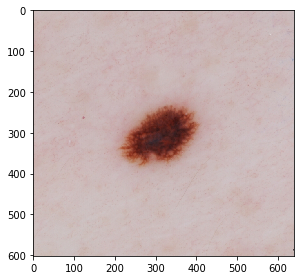

In [ ]:
image = imread("/content/drive/MyDrive/Colab Notebooks/melanoma.jpeg")

print(type(image))   # NumPy ndarray
imshow(image);       # note the origin in the top left corner

**What is an image?**

An image is simply an array of pixels. Each pixel is typically represented by 1 byte (gray pixel) or 3 bytes (colour pixel, where each pixel represents the intensity of red, green and blue respectively). A byte is a collection of 8 bits, i.e. it has $2^8$ possible values, between 0 - 255. The more pixels an image has, the higher the resolution.

An image can be 2D (greyscale), where 0 is completely black and 255 is completely white, or 3D where the three dimensions represent RGB channels.

![ ](https://drive.google.com/uc?export=view&id=1_xOAHXRDiHc3gAYvmfQIvgwx8oqr-jmZ)

In [ ]:
print(image.shape)  # shape
print(image.ndim)   # number of dimensions
print(image.size)   # number of pixels

(602, 639, 3)
3
1154034


## Global Image Transformations

Global means considering the image as a whole, rather than local neighbourhoods around specific pixels (which we will come to).

**Colour to greyscale**

One of the most common transformations is to convert a colour image into greyscale. This is useful as it reduces the dimension of the image from 3 to 2, which will reduce the computational complexity of working with this image and memory required to store it. Often, the most important features are just as or even more identifiable in greyscale compared to colour.

This conversion is done using the `rgb2gray()` function, which uses the formula `Y = 0.2125 R + 0.7154 G + 0.0721 B`.

**Note** - the greyscale image pixels are normalised to the **range 0-1**, dividing by 256.

(602, 639)

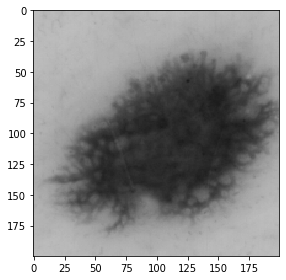

In [ ]:
greyscale_image = rgb2gray(image);
imshow(greyscale_image);

greyscale_image.shape    # shape of greyscale image - no colour channel
#greyscale_image.ndim    # dimension is now 2

**Rotation**

We can rotate the image using the `rotate()` function. This could be applied to ensure a common alignment of images before trying to classify.

(602, 639, 3)
(602, 639, 3)
(784, 806, 3)


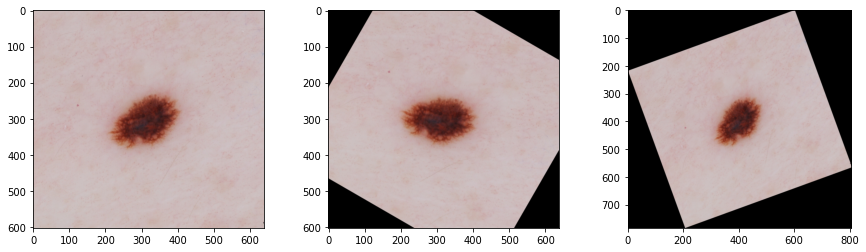

In [ ]:
# Rotate an image by a certain angle (in degrees, anti-clockwise) around its centre
# Doesn't automatically resize to fit the entire image

rotated_image = rotate(image, angle = -30)   # Rotate image by 30 degrees clockwise - default, resize is off

rotated_resized_image = rotate(image, 20, resize= True)   # Resize so the whole image fits

print(image.shape)
print(rotated_image.shape)
print(rotated_resized_image.shape)    # Notice how the image is now bigger - more pixels are needed to fit the whole image

# Show comparison between original, rotated and rotated and resized images.
fig, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
ax1.imshow(image)
ax2.imshow(rotated_image)
ax3.imshow(rotated_resized_image)

**Rescaling**

We can rescale the image by a certain factor using the `rescale()` function. It is also possible to change the dimension using the `resize()` function.

(602, 639, 3)
(452, 479, 3)


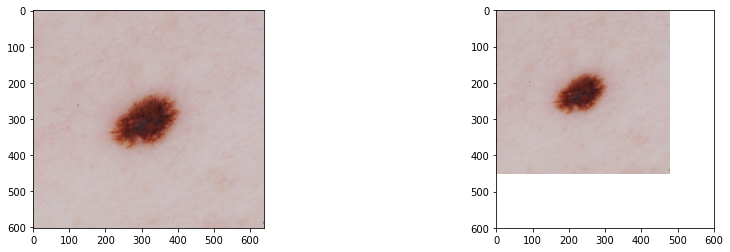

In [ ]:
# Rescale image by a certain factor

rescaled_image = rescale(image, 3/4, multichannel = True)     # Multichannel = True specifies that the last axis represents multiple channels (i.e. RGB)
                                                              # See what happens to shape without setting this parameter.
print(image.shape)
print(rescaled_image.shape)

# Show comparison between original and rescaled image.
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax1.imshow(image)
ax2.imshow(rescaled_image)
ax2.set(xlim=(0, 600), ylim=(600, 0));

**Histogram**

A histogram shows the distribution of pixels of a certain intensity (i.e. a plot of number of pixels vs intensity). This provides useful information about the content and contrast of a particular image, e.g. if the histogram has huge peaks at high values and nothing at low values, it is a mostly light image. A histogram can be plotted for each colour channel of a RGB image.

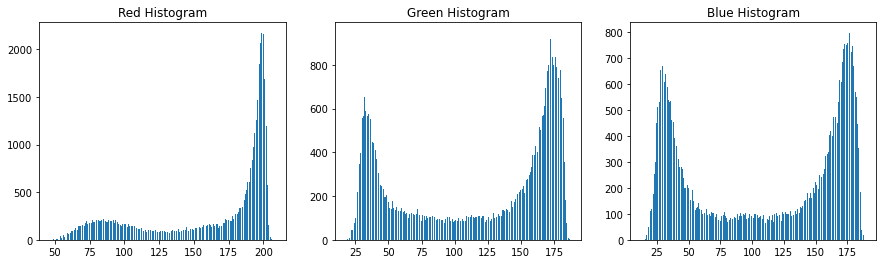

In [ ]:
red_image = image[200:400, 200:400,0]    # Extract the red channel
green_image = image[200:400,200:400,1]  # Green channel
blue_image = image[200:400,200:400,2]   # Blue channel

#print(red_image.shape)    # Verify that this is now 2D

# Plot RGB histograms
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4));

ax1.hist(red_image.ravel(), bins = 256);   # ravel() turns the array into a 1D array, 0 = black, 255 = white
ax2.hist(green_image.ravel(), bins = 256);
ax3.hist(blue_image.ravel(), bins = 256);
ax1.title.set_text('Red Histogram');
ax2.title.set_text('Green Histogram');
ax3.title.set_text('Blue Histogram');

**Contrast Enhancement - Histogram Equalisation**

The global contrast of an image can be improved through a process called histogram equalisation. This works for images which have a narrow range of intensities. It aims to evenly spread out the intensity in order to enhance minor variations in intensity and make use of the full range of available intensities (rather than just relying on a narrow band).

The formula for performing histogram equalisation is:
$ i_n = i_{max}\frac{C(i)}{N} $ where:

$ i_n $ = new pixel intensity for pixel n

$ i_{max} $ = maximum intensity

$ C(i) $ = the cumulative distribution of the original image (i.e. how many pixels have intensity $i$ or below)

$ N $ = total number of pixels

This works by assigning a new intensity which is the fraction of the total number of pixels in the range $(0-i)$ multiplied by the maximum intensity. In this way, the minimum intensity for which there are pixels in the original image gets mapped to near 0 and the maximum gets mapped to 255 - producing an even spread across intensities.

However, as it is a global transformation, histogram equalisation doesn't perform well when the image has distinct regions which we would ideally like to enhance separately. This can be seen in the example below.

Contrast Limited Adaptive Histogram Equalisation (CLAHE) can be used to apply histogram equalisation locally over different regions of the image (i.e. it is not a global transformation) - this performs much better for improving the contrast of the melanoma.

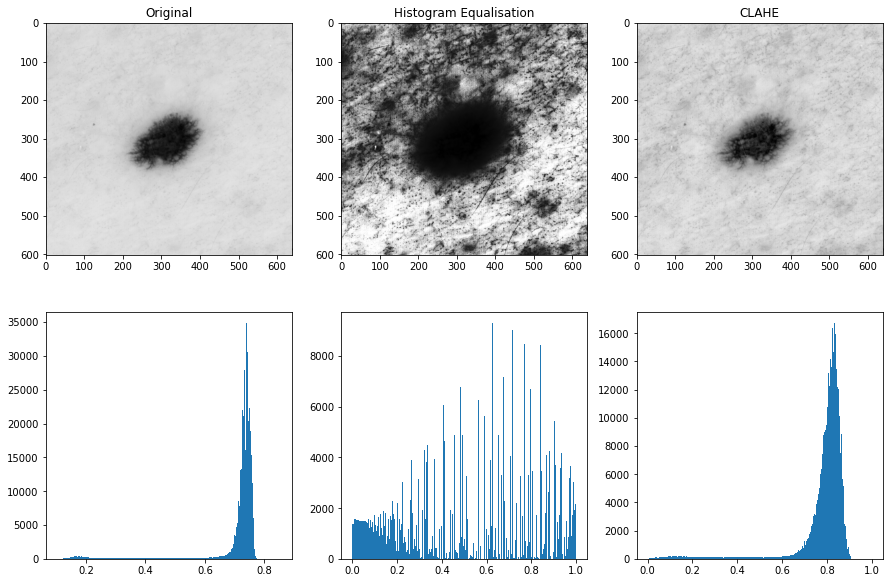

In [ ]:
equalised_histogram_image = equalize_hist(greyscale_image);               # Histogram equlisation- improves contrast on the whole image
CLAHE_image = equalize_adapthist(greyscale_image);    # CLAHE- local histogram equalisation

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, figsize=(15,10));
ax1.imshow(greyscale_image, cmap='gray')
ax2.imshow(equalised_histogram_image, cmap= 'gray')
ax3.imshow(CLAHE_image, cmap= 'gray')
ax1.title.set_text('Original')
ax2.title.set_text('Histogram Equalisation')
ax3.title.set_text('CLAHE')
ax4.hist(greyscale_image.ravel(), bins = 256);
ax5.hist(equalised_histogram_image.ravel(), bins = 256);
ax6.hist(CLAHE_image.ravel(), bins = 256);

## Thresholding

Thresholding is a method of binarising an image, by setting all pixel values below a certain threshold to 0 (black) and the rest to 1 (white). This is useful for **segmentation , object detection , finding edges / contours etc**.
It works best on high contrast greyscale images.

**Manual Thresholding**

We choose the threshold by trial and error, depending on the purpose.

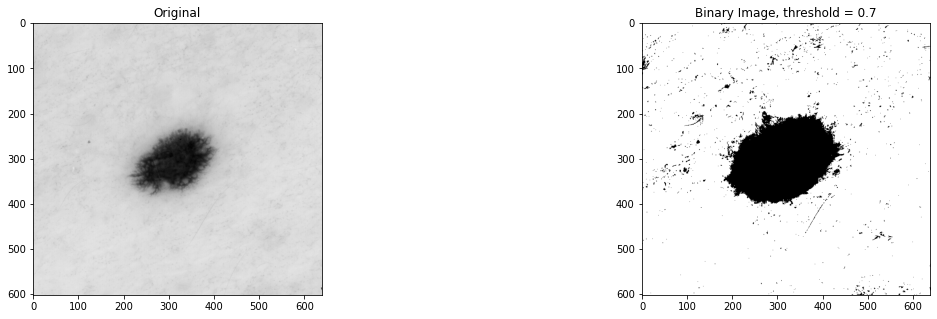

In [ ]:
threshold = 0.7;

binary_image = greyscale_image > threshold;   # if the greyscale image is lighter than the threshold, set as 1

# Compare results
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5));
ax1.imshow(greyscale_image, cmap = 'gray');
ax2.imshow(binary_image, cmap = 'gray');
ax1.title.set_text('Original');
ax2.title.set_text('Binary Image, threshold = ' + str(threshold))


**Global thresholding**

Rather than a trial and error approach to choosing the threshold, an algorithm can be used. There are a number of different methods, and Skimage's `try_all_threshold()` function tries them all and compares them. For example, the mean algorithm sets the threshold to the mean of pixel values.

The result of each of these algorithms is to produce a single global threshold.

A further exercise is to read about how each algorithm works.


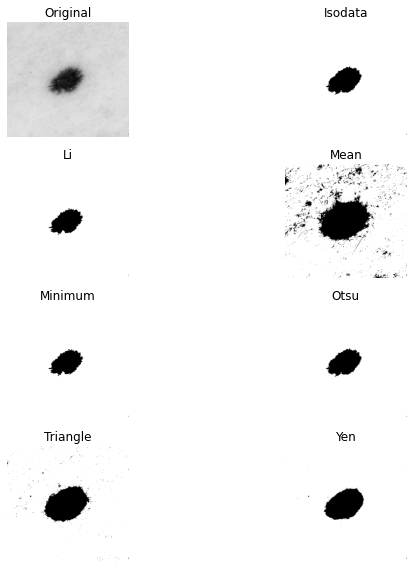

In [ ]:
fix, ax = try_all_threshold(greyscale_image, figsize = (10,8), verbose = False);

This works pretty well when the background is uniform but what about when the background is non-uniform?

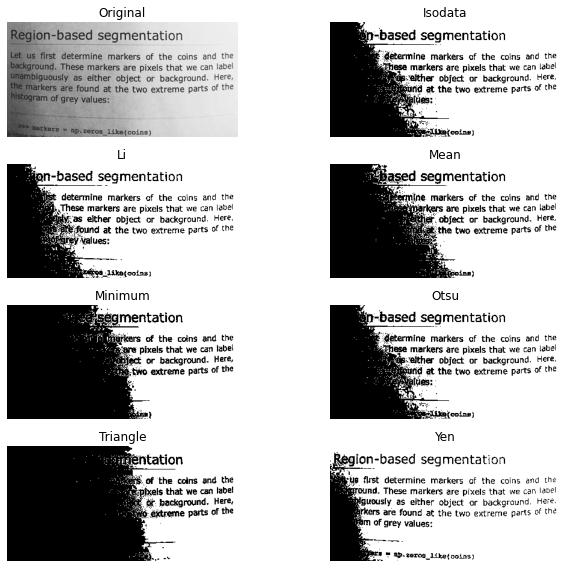

In [ ]:
page_image = data.page();   # Load image with uneven background

fix, ax = try_all_threshold(page_image, figsize = (10,8), verbose = False);

The global thresholding algorithms perform terribly in this case, because of the uneven background. The variations in brightness of the background across the whole image will affect the threshold value.

**Local thresholding**

Local thresholding solves this problem by focusing on pixel regions ( neighbourhoods) to account for uneven background brightness in different regions. This is implemented using the `threshold_local()` function. Each pixel now has its own threshold, which is the weighted mean of the neighbourhood pixels.

The `block_size` parameter determines the size of neighbourhood considered, `method ` sets the weighting method e.g. gaussian, arithmetic mean etc, and `offset` is a constant subtracted from the weighted mean to calculate the local threshold value.

<class 'numpy.ndarray'>
(191, 384)
(191, 384)


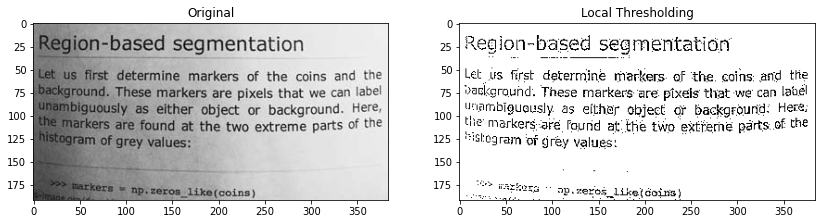

In [ ]:
local_thresh = threshold_local(page_image, block_size = 3, method = 'gaussian', offset = 0.65)   # Play around with the parameters to find the optimal threshold

print(type(local_thresh))   # each pixel now has its own threshold value -- the weighted mean of the neighbourhood pixels
print(local_thresh.shape)
print(page_image.shape)     # Threshold array and original image have the same dimensions

binary_image_local = page_image > local_thresh;

# Compare results
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6));
ax1.imshow(page_image, cmap = 'gray');
ax2.imshow(binary_image_local, cmap = 'gray');
ax1.title.set_text('Original');
ax2.title.set_text('Local Thresholding');

This is much improved compared to the global thresholding case!

## Filtering

Filtering is the process of calculating new intensity values for each pixel, based on a weighted sum of the pixels in a neighbourhood surrounding that pixel. The weights are determined by the values of a **kernel** which is a smaller matrix that is scanned through each pixel to perform multiplications and summations.

This is mathematically equivalent to the operation of **convolution** (with a spatially flipped kernel, they are equivalent if the kernel is symmetric).

![ ](https://drive.google.com/uc?export=view&id=1l1x9VdViSKEeKDXl3QQjYONVlV_8eh_a)

Example:
![ ](https://drive.google.com/uc?export=view&id=1r7pmEpwjm2lRYbHA-ZWq3g7Svi9C0Oxb)


*What about at the edges?*

There are a number of ways to deal with the boundaries e.g. zero padding. This will usually be a parameter in the Skimage function, and details of these can be found here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html#scipy.ndimage.convolve .

**Smoothing**

Smoothing, or blurring, is useful in removing noise or fine details which provide no valuable extra information for a machine learning algorithm. One of the most common smoothing techniques is **Gaussian smoothing** - which applies a Gaussian weighted kernel to the image. The values in the kernel are a discrete approximation to a 2D Gaussian as shown below for a 3x3, 5x5 and 7x7 kernel.

![ ](https://drive.google.com/uc?export=view&id=1rQAzGZhuRUut8Arn7LmVPzbdqoU03ObY)

2D Gaussian:
![ ](https://drive.google.com/uc?export=view&id=1c6q1znNOtRrfntlcphrblooiPxaIuFCV)





This is achieved using the `gaussian()` function from Skimage. The parameter `sigma` controls the standard deviation of the Gaussian (i.e. how quickly it tapers off) and the parameter `truncate` sets the size of the kernel (the default is at 4 standard deviations).

**What happens when sigma is increased?**

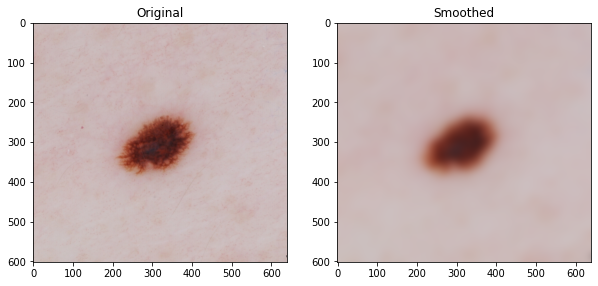

In [ ]:
smoothed_image = gaussian(image, multichannel = True, sigma = 10, truncate = 3);   # Increasing sigma increases the amount of blur.

# Compare smoothed image to original image
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5));
ax1.imshow(image);
ax2.imshow(smoothed_image);
ax1.title.set_text('Original');
ax2.title.set_text('Smoothed');

**Can you guess what this filter does?**

$ \frac{1}{9}
  \left[ {\begin{array}{cc}
    1 & 0 & -1 \\
    2 & 0 & -2  \\
    1 & 0 & -1
  \end{array} } \right]
$



It detects vertical edges.

The result gives zero if the region is constant (summation comes to zero because of the negatives) and gives large negative values for bright to dark transitions.

**Edge detection**

Edges can be detected as sudden changes in intensity, using vertical and horizontal **Sobel** filters:

Vertical Sobel:
$ \frac{1}{9}
  \left[ {\begin{array}{cc}
    1 & 0 & -1 \\
    2 & 0 & -2  \\
    1 & 0 & -1
  \end{array} } \right]
$

Horizontal Sobel:
$ \frac{1}{9}
  \left[ {\begin{array}{cc}
    1 & 2 & 1 \\
    0 & 0 & 0  \\
    -1 & -2 & -1
  \end{array} } \right]
$

Applying these both to an image detects edges.


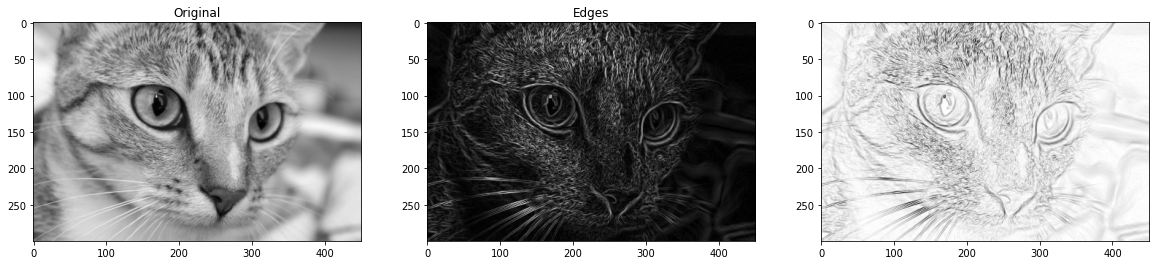

In [ ]:
cat_image = rgb2gray(data.cat());   # Using the data module from skimage to load an image
                                    # Convert to greyscale (colour doesn't matter for edge detection)

CLAHE_cat = equalize_adapthist(cat_image);    # Use CLAHE to enhance the contrast of the image to make edge detection even easier

cat_edges = sobel(CLAHE_cat)    # Apply Sobel filter

# Compare results
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,5));
ax1.imshow(cat_image, cmap = 'gray');
ax2.imshow(cat_edges, cmap = 'gray');
ax3.imshow(invert(cat_edges), cmap = 'gray');   # Invert black and white
ax1.title.set_text('Original');
ax2.title.set_text('Edges');

The Sobel filter is not the only method for edge detection. It can be an excerise to investigate other methods e.g. the Canny algorithm, the Kovalesky algorithm, https://en.wikipedia.org/wiki/Edge_detection

## Segmentation

Segmentation is concerned with dividing up an image into similar areas, based on contrast, colour or brightness. There is a whole Skimage submodule for segmentation, showing how fundamental and extensively used it is.

We will not cover this in much depth, but demonstrate an example.

The Simple Linear Iterative Cluster (SLIC) uses k-means clustering to find segments.

<ipython-input-32-f4c22a8aaa2b>:4: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(coffee_image, n_segments = n);    # Generate segment labels - see what happens when n_segments is increased.
<ipython-input-32-f4c22a8aaa2b>:6: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  segmented_image = label2rgb(segments, coffee_image, kind ='avg')/256;   # Convert labels back to RGB values


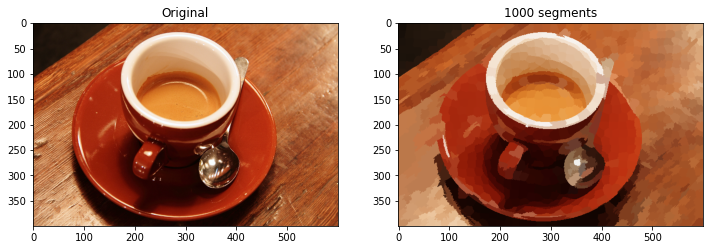

In [ ]:
coffee_image = data.coffee();

n = 1000;    # number of segments
segments = slic(coffee_image, n_segments = n);    # Generate segment labels - see what happens when n_segments is increased.

segmented_image = label2rgb(segments, coffee_image, kind ='avg')/256;   # Convert labels back to RGB values
                                                                           # Output is a float ndarray, normalise so image is in the range of imshow (0-1 for float)
# kind = 'avg' replaces each labeled segment with its average colour.

# Compare results
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5));
ax1.imshow(coffee_image);
ax2.imshow(segmented_image);
ax1.title.set_text('Original');
ax2.title.set_text(str(n) + ' segments');


## Conclusion

We have introduced the core concepts of image processing, breaking down an image into an ndarray of numbers which we can manipulate globally or locally to produce a new image which contains useful information for machine learning. We have looked at colour and greyscale images, rotation, rescaling, histograms, histogram equalisation, thresholding, filtering, smoothing, edge detection and segmentation.

## Exercise

There are many more functions, filters and image processing algorithms. Try loading and manipulating your own images using the Skimage library (documentation: https://scikit-image.org/). You could partner up, swap processed images and try to get from the original to your partner's processed image using the available functions and your knowledge!

## References / further reading

This tutorial was largely based on these two articles:
https://towardsdatascience.com/massive-tutorial-on-image-processing-and-preparation-for-deep-learning-in-python-1-e534ee42f122

https://towardsdatascience.com/massive-tutorial-on-image-processing-and-preparation-for-deep-learning-in-python-2-14816263b4a5

Sobel filter:
https://medium.com/analytics-vidhya/sobel-edge-filter-daf07a462ff4

## Image credits

https://www.kaggle.com/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection

https://www.researchgate.net/figure/Discrete-approximation-of-the-Gaussian-kernels-3x3-5x5-7x7_fig2_325768087

https://www.programmersought.com/article/42604861507/

https://medium.com/swlh/image-processing-with-python-convolutional-filters-and-kernels-b9884d91a8fd

https://towardsdatascience.com/convolution-neural-network-for-image-processing-using-keras-dc3429056306